In recent years, the use of machine learning models within organizations has become more and more common. With applications such as customer churn prediction, fraud detection or predicting response to a marketing campaign, predictive models have proven to be a powerful tool within many businesses domains. Predictive models create value by allowing businesses to respond and adapt quickly to insights from data. The more accurate predictive models get, the better they can be used to optimize processes thus the more value they create. 

Hence, many data scientist seek for the model with the highest accuracy, which are often complex, non-linear models such as XGBoost or Random Forest. While these models are very powerful, they also come with a significant disadvantage: due to their complexity, it is often difficult to find out why a certain prediction was made and how variables contributed to the decision. This is problematic because it is important for organizations to use data science methods in a responsible and ethical manner. Especially in sensitive cases with personal data involved, organizations need to be able to demonstrate that their models and processes are justifiable and not discriminating. This includes having an open and transparent decision making process, avoiding the so-called black box model. The second reason why we want to avoid black box models, is that explanations of predictions provide valuable insights. For example in churn prediction, it is not only valuable to have an accurate prediction of whether a customer is likely to leave, but also to know how the variables are related to churn. In short, opening the black box provides both transparency and actionable insights that organizations can benefit from.

Two well-known methods for explaining tree-based models such as RandomForest and XGBoost are SHAP and LIME. In this article, we will demonstrate how these work and how they can be used to open the black box of machine learning models. The following section will elaborate on the difference between global and local interpretability, followed by a short theoretical description of SHAP and LIME. We then train a RandomForest model and demonstrate how SHAP and LIME can be used for model explanation and compare the two methods. The focus of this article will be on the practical implementation of the two methods, so I will refer to other articles for more theoretical background.

## Global vs. Local Interpretability

Before we start, it is important to distinguish between global an local interpretability. Global interpretability refers to insights in how predictor variables generally contribute to the target variable, either positive or negative. It allows us to get a sense of the importance or relevance of the predictors in our model, and how they relate to the target variable.

In contrast, local interpretability refers to insights in why an individual case received its prediction and how predictor variables contributed to the prediction. This is especially useful in models like RandomForest and XGBoost, because in these kind of models the contribution of variables to the prediction can vary per individual case.

## SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explaining machine learning models. It is based upon Shapley values, that quantify the contribution that each feature brings to the outcome of the model. Every prediction starts with the expected value (or average prediction) as the base value, and the SHAP value of each feature tells us how that feature contributes to the actual predicted probability relative to the base value. Hence, the final prediction is the sum of the average prediction and all the SHAP values.

In the first place, SHAP is a method for local interpretation of the model, because SHAP values quantify the contribution of each feature to a single prediction case. However, SHAP can also be used for global interpretation, where the SHAP values of multiple prediction cases are combined or aggregated to get a sense of the more general contribution of the features to the outcome. If you want to know more about how SHAP values are actually computed, I recommend you to read this article: https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

## LIME

Another popular method for explaining machine learning models is LIME, which builds upon four basic principles:
- **L**ocal: The explanation must be locally faithful, i.e. it must correspond to how the model behaves in vicinity of the instance being predicted.
- **I**nterpretable: Provide a qualitative understanding between the input variables and the output. The best way is to use a linear model with few variables.
- **M**odel-Agnostic: You can apply any model – i.e. Deep Learning Model, Regression, XGBoost, etc.- and it will always work. This also holds for future models.
- **E**xplanation: Explains predictions on the individual level.

LIME works by fitting a so-called local surrogate model that approximates the predictions of the underlying black box model. In contrast to SHAP, LIME can only be used for local interpretation, because the locally fitted surrogate model only applies in proximity of the data point being explained.

In the following section, we will prepare our dataset and fit a model, followed by a demonstration how SHAP and LIME can be used to explain the model. We will demonstrate the different functions and features of the SHAP and LIME package and compare them.

## Preparing some data

Imagine you are working for a telecom company and you are responsible for the collection of subscription payments. In this role, it is your job to minimize defaults by customers. You decide to use customer data to train a model that can be used to predict whether someone is likely to be a defaulter or not. The model can then be used to recognize defaults in an early stage so that measures can be taken to minimize payment arrears. We are working with a dataset that contains information on mobile phone subscriptions, including an indicator for whether that subscription is defaulted. After training a model that predicts defaults, we are going to use SHAP and LIME to explain the model and explore how our predictor variables relate to our target variable.

In [ ]:
#Firstly, we install the required packages:

!pip install SHAP
!pip install lime
!pip install Pillow==9.0.0 # The newest version results in plotting issues.

In [ ]:
import pandas as pd

# In 90% of the cases, subscr_default has the same value as ind_debt_collector.
print('Proportion of cases where subscr_default == ind_debt_collector:', (df.subscr_default == df.ind_debt_collector).mean())

# We therefore drop the indicator for debt collector.
df = df.drop('ind_debt_collector', axis=1)

# Balance the dataset by undersampling the majority class
# df_y1 = df[df.subscr_default == '1']
# df_y0 = df[df.subscr_default == '0'].sample(len(df_y1), random_state=17)

# df_balanced = pd.concat([df_y1, df_y0])

Proportion of cases where subscr_default == ind_debt_collector: 0.8999975344559777

We have loaded and prepared a dataset in the variable `df` that describes whether a subscription is defaulted or not. We can preview the data using `df.head():`

In [ ]:
df.head()

Out[5]:

subscr_default 
 monthly_subscr_amount 
 price_mobilephone 
 avg_min_call_wk 
 nr_subscr_started_last6months 
 ind_payment_arrears 
 nr_damage_reports 
 ind_customercontact_lastmonth 
 nr_visits_MYCALL_last3months 
 nr_active_subscr 
 nr_subscr_total 
 max_remaining_days_total 
 age 
 ind_self_employed 
 days_since_startdate_subscr 
 ind_male 
 ind_Apple18 
 ind_Huawei19 
 ind_Motorola20 
 ind_Nokia21 
 ind_OnePlus22 
 ind_Oppo23 
 ind_Samsung24 
 ind_Sony25 
 ind_Apple26 
 ind_Huawei27 
 ind_Motorola28 
 ind_Nokia29 
 ind_OnePlus30 
 ind_Oppo31 
 ind_Samsung32 
 ind_Sony33 
 
 
 
 
 0 
 0 
 15 
 600.0 
 188.460007 
 0 
 0 
 0 
 0 
 1 
 1 
 5 
 31 
 47.0 
 1 
 743.0 
 1 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 1 
 0 
 20 
 200.0 
 223.500000 
 0 
 0 
 1 
 0 
 1 
 1 
 2 
 138 
 27.0 
 0 
 1415.0 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 
 
 2 
 0 
 45 
 400.0 
 264.000000 
 2 
 0 
 1 
 0 
 5 
 5 
 7 
 569 
 41.0 
 1 
 260.0 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 
 
 3 
 1 
 35 
 600.0 
 233.429993 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 5 
 50.0 
 1 
 785.0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 4 
 0 
 10 
 800.0 
 149.520004 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 36 
 36.0 
 1 
 575.0 
 1 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0

Our dataset contains information on mobile phone subscriptions, and the column `subscr_default` indicates whether that subscription is defaulted. Therefore, `subscr_default` is our target variable that we are going to predict. Our predictor variables contain information on the subscriptions, such as the monthly amount of the subscription, the price of the mobile phone, and the average minutes of calls per week. We will first train a model in order to predict default, and then we will demonstrate how SHAP and LIME can be used to explain the predictions of the model. Please note that since we want to explain SHAP and LIME, we need a trained model, but the focus of this article is not on how to train a prediction model. If you want to learn more about how to train a predictive model in python, I recommend you to read our series ['No Data Scientist is the Same'](https://www.theanalyticslab.nl/no-data-scientist-is-the-same-introducing-our-data-science-rock-stars/). In this series, we go into detail on how different types of data scientists build predictive models.

## Training the model

In the code below, we first separate our target variable from our predictor variables, followed by a train/test split in order to be able to validate our model performance. We then train a Random Forest model and assess it's performance on test dataset.

Accuracy train set: 0.8289598816526363
Accuracy test set: 0.818184308568924
 precision recall f1-score support

 0 0.82 0.98 0.89 28104
 1 0.79 0.28 0.42 8400

 accuracy 0.82 36504
 macro avg 0.81 0.63 0.66 36504
weighted avg 0.81 0.82 0.78 36504

Out[7]:

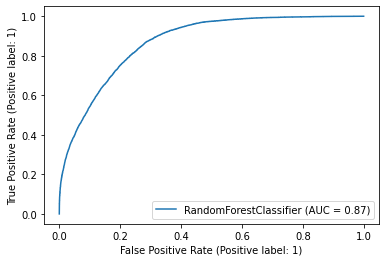

<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7fe0c1e27c10>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

# Specifying our target variable:
target = 'subscr_default'

# Seperating our target variable from our features:
y = df[target]
X = df.drop(target, axis = 1)

# Splitting the dataset into a 70% train and 30% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 17)

# Initialize and fit the model:
rf = RandomForestClassifier(max_depth=10).fit(X_train, y_train)

# Predict: 
y_pred_rf = rf.predict(X_test)
y_pred_rf_train = rf.predict(X_train)

#Evaluate
print("Accuracy train set:", accuracy_score(y_train, y_pred_rf_train))
print("Accuracy test set:", accuracy_score(y_test, y_pred_rf))

cr = classification_report(y_test, y_pred_rf)
print(cr)

plot_roc_curve(rf, X_test, y_test)

## Global model interpretation

Not bad, our model a has fairly decent predictive value with an AUC of 0.87. Now it's time for some interpretation of our model! We start off with interpreting our model on the global level, so we can get an idea of the general relations between variables in the model. Scikit-learn has built in the attribute `feature_importances_` to get a first idea of what features are important in the model. We can access the feature importances by using `rf.feature_importances_`, and we create a dataframe to store the feature importance values and their corresponding feature names:

In [ ]:
df_fi = pd.DataFrame()
df_fi['feature'] = X.columns
df_fi['importance'] = rf.feature_importances_

df_fi.sort_values('importance', ascending=False).head(10)

Out[13]:

feature 
 importance 
 
 
 
 
 2 
 avg_min_call_wk 
 0.217728 
 
 
 0 
 monthly_subscr_amount 
 0.141671 
 
 
 7 
 nr_visits_MYCALL_last3months 
 0.137442 
 
 
 6 
 ind_customercontact_lastmonth 
 0.103688 
 
 
 13 
 days_since_startdate_subscr 
 0.071041 
 
 
 10 
 max_remaining_days_total 
 0.054425 
 
 
 9 
 nr_subscr_total 
 0.040570 
 
 
 4 
 ind_payment_arrears 
 0.037278 
 
 
 1 
 price_mobilephone 
 0.027176 
 
 
 11 
 age 
 0.025857

## SHAP for global interpretation

Great! We now know that the *average minutes of calls per week* is the most important feature in our model, followed by the *monthly subscription price* and *number of visits to the online portal (MyCall)*. However, this only tells us that these features are important for predicting defaults, but not **how** these features are related to defaults. In other words, we don't know whether a high number of `avg_min_call_wk` in general contributes *positively* or *negatively* to our prediction. This is what we can use SHAP for!

The SHAP package computes SHAP values by iteratively giving input to the prediction model, while leaving a different feature out every iteration. By doing so, it can quantify the contribution that each feature brings to the prediction. Please note that SHAP values for a prediction only apply to that specific prediction, and other predictions are likely to have different SHAP values. So because we want to start off with globally interpreting our model, we want to compute SHAP values for more than one data point. In the code below, we take a subsample of 5000 data points. We initialize a SHAP-explainer for our random forest model by using `shap.TreeExplainer(rf)`, and we use the `.shap_values()` method to compute the SHAP values for our subsample of data points:

In [ ]:
import shap
from shap import TreeExplainer

X_train_sample = X_train.sample(5000, random_state=17) # Take a sample because calculating SHAP values for the entire dataset would take way too much time.

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_sample)

In [ ]:
print(f"length of shap_values: {len(shap_values)} \n")
print(f"shape of elements within shap_values: {[i.shape for i in shap_values]} \n")

shap_values[0][1]#class0
shap_values[1][1] # class 1

length of shap_values: 2 

shape of elements within shap_values: [(5000, 31), (5000, 31)] 

Out[15]: array([-4.56718599e-02, -1.41225035e-02, -4.05513129e-02, 1.57736486e-03,
 -1.14926876e-02, -3.42238141e-03, -1.76614199e-02, 2.89887334e-02,
 1.70321567e-03, 6.17229075e-03, 6.54419957e-03, -9.59032723e-03,
 -7.70774922e-03, -2.67559185e-02, -4.46089375e-04, -6.78523493e-05,
 -1.14005510e-03, -1.01457239e-03, -2.35851244e-05, 7.14161133e-05,
 -8.33485924e-03, 7.13546794e-03, -1.16498976e-05, 5.43908687e-05,
 -1.38253586e-03, -2.68148239e-03, -3.35076536e-05, -3.51248456e-05,
 -6.52759831e-03, 6.30180071e-03, -5.33371500e-06])

`explainer.shap_values()` returns a list of length 2, where each element is a matrix of SHAP values with size n_samples x n_features. The length of this list is 2, because the `predict_proba` method of our RandomForest model returns an array of length two, holding the predicted probabilities for each of the classes. As a result, we also get separate SHAP values for each of the classes: `shap_values[0]` holds the SHAP values that quantify the contribution of features for predicting class 0 (no defaulter) and `shap_values[1]` holds the SHAP values that quantify the contribution of features towards predicting class 1 (defaulter). Note in the output above that these have the exact same magnitude, but in the opposite direction (negative gets positive and vice versa).

In our case, we want to explain how variables contribute to predicting if someone is a defaulter, which is class 1. We therefore use `shap_values[1]` as the values to visualize. We can do so by using the `shap.summary_plot()` function:

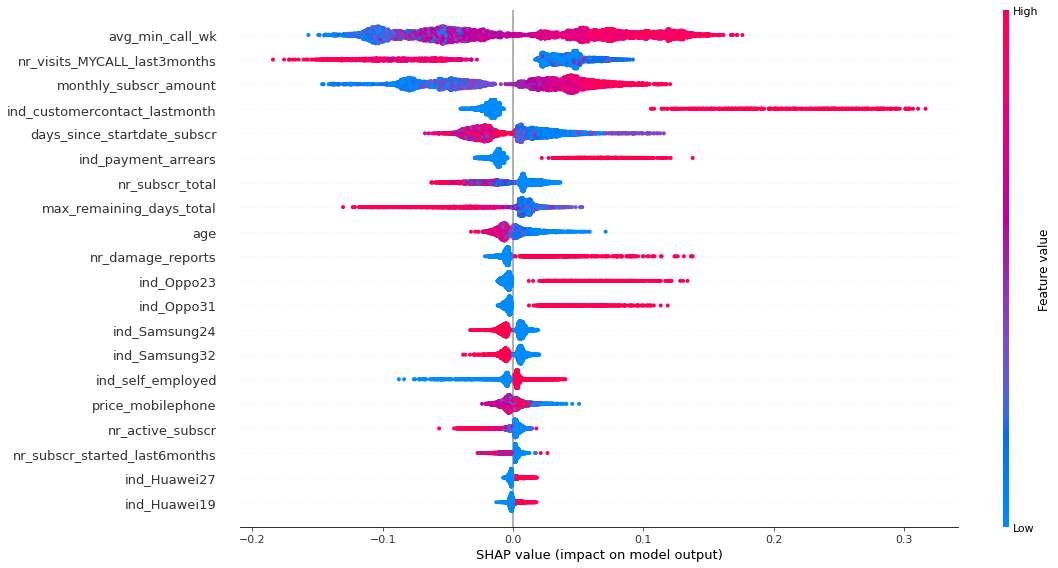

In [ ]:
 from matplotlib import pyplot as plt

f = plt.figure()
shap.summary_plot(shap_values[1], X_train_sample, plot_type='dot', show=False, plot_size=[16,8])

The dots in the plot above visualize the SHAP values for the 5000 records in our subsample. The color of a dot represents the feature value for the specific data point, and the position on the x-axis displays the corresponding SHAP value. A high SHAP value indicates a higher (positive) predicted probability by the model, whereas a lower (negative) SHAP value contributes negatively to the predicted probability by the model. If we look at the `avg_min_call_wk` feature of the model, we see that generally, high values for the average minutes of calls per week correspond with high SHAP values and thus, a higher probability of someone being a defaulter. Conversely, high value for the number of visits to the online portal (MyCall) generally indicates a lower probabilty of someone being a defaulter. Similar to sklearn's `feature_importance_` attribute, the higher a feature appears in the summary plot, the more important or relevant the feature is in the model. The advantage of the SHAP summary plot is that we not only can see what the important features in our model are, but also how (positive or negative) feature values relate to the prediction.

In the summary plot above, color is used to represent the value of the features, and position on the x-axis is used to represent the SHAP values. This allows us to get a general idea of the relation between feature values and SHAP values, but if we want to zoom in on a feature and have a more detailed insight, SHAP offers the `dependence_plot` to explain the relation between individual features and the target variable. For instance, the `dependence_plot` below shows that when the monthly subscription amount exceeds 30, the probability to the subscription being defaulted increases significantly.

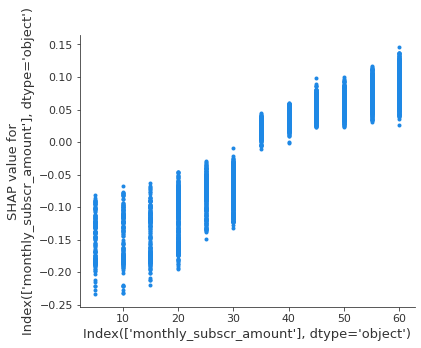

In [ ]:
shap.dependence_plot(X_train_sample.columns.get_indexer(['monthly_subscr_amount']), shap_values[1], X_train_sample, interaction_index=None) 

Although we now have a general idea of how our features contribute to the model predictions, we still have no insight into the individual predictions. If we want to know how all features together result in the final prediction, we are locally interpreting our model. Luckily SHAP also offers methods for explaining individual predictions!

# Explain individual predictions

Let's say that now that we have a general idea of the relation between our features and target variable, we decide to take our model into production and send all customers with a predicted probability above 0.8 an extra reminder to pay for their subscription. After sending the payment reminders, a customer, Jimmy, calls and asks why he has received a reminder while his friend Jack hasn't. In order for an organization to comply with GDPR, you are obligated to provide a customer's data when requested. In this case, you are requested to provide the data on the basis of which the customer received the payment reminder.

We can use the `shap.force_plot()` function to see how features contributed to the individual prediction for this person:

<IPython.core.display.HTML object>

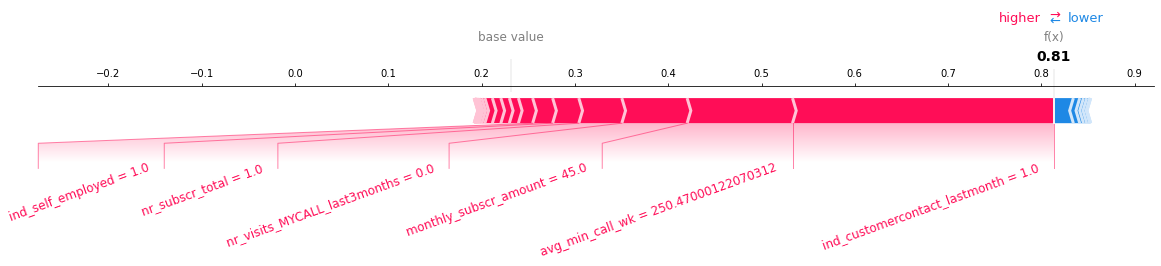

In [ ]:
shap.initjs()

j = 49 # index of person with high probability (>0.8)

explainer = shap.TreeExplainer(rf)
shap.force_plot(explainer.expected_value[1], # Note that we use the expected value of class [1] (defaulter) as a base value
                shap_values[1][j, :], # So we also want the SHAP vaues for class [1]
                X_train_sample.iloc[j, :], 
                matplotlib=True,
                text_rotation=20)

In [ ]:
import numpy as np

expected_value = y_train.astype(np.float32).mean()

print('Proportion of samples with class 1 in training dataset: ' + str(expected_value))

Proportion of samples with class 1 in training dataset: 0.23102392

The plot above explains why a probability of 0.81 was assigned to Jimmy. Note that the base value represents the expected value of our model, which is the proportion of samples with class 1 in our training dataset. In other words, this is the probability that a random person in our training dataset is a defaulter. Based on the information that we have about Jimmy, the probability increases towards 0.81. The features in red are the features that contributed most positively to the predicted probabilty, while the features in blue contributed negatively to the probability. We can see that the fact that Jimmy has been in contact with our company (`ind_customercontact_lastmonth`) has a strong positive effect on the predicted value. This aligns what what we would expect according to the summary plot that we saw earlier, where all the red dots (`ind_customercontact_lastmonth = 1`) have positive SHAP-values. Furthermore, Jimmy calls on average 250 minutes per week, and `avg_min_call_wk` appears in red, which indicates that this is also one of the reasons that Jimmy's subscription was predicted to be defaulted.

Although the force plot reveals the positive or negative contribution of feature values to the prediction, we do not see how much probability is added to the baseline value for each feature value. A way to visualise this, is by using the waterfall plot. For this plot, we first need to generate another type of explainer and differently prepared shap values. As the run time shows, this method is quite expensive and therefore slow. However, it provides a nice breakdown of how the variables contributed to the final predicted probability. Note that we are still looking at the same customer, Jimmy.

5%|= | 451/10000 [00:11<03:52]  5%|= | 496/10000 [00:12<03:49]  5%|= | 539/10000 [00:13<03:48]  6%|= | 580/10000 [00:14<03:47]  6%|= | 622/10000 [00:15<03:46]  7%|= | 669/10000 [00:16<03:43]  7%|= | 713/10000 [00:17<03:41]  8%|== | 758/10000 [00:18<03:39]  8%|== | 803/10000 [00:19<03:37]  8%|== | 847/10000 [00:20<03:36]  9%|== | 890/10000 [00:21<03:34]  9%|== | 933/10000 [00:22<03:33]  10%|== | 977/10000 [00:23<03:32]  10%|== | 1019/10000 [00:24<03:31]  11%|== | 1065/10000 [00:25<03:29]  11%|== | 1111/10000 [00:26<03:28]  12%|== | 1155/10000 [00:27<03:26]  12%|== | 1200/10000 [00:28<03:25]  12%|== | 1244/10000 [00:29<03:24]  13%|=== | 1288/10000 [00:30<03:22]  13%|=== | 1326/10000 [00:31<03:22]  14%|=== | 1369/10000 [00:32<03:21]  14%|=== | 1409/10000 [00:33<03:21]  15%|=== | 1454/10000 [00:34<03:19]  15%|=== | 1494/10000 [00:35<03:19]  15%|=== | 1534/10000 [00:36<03:18]  16%|=== | 1576/10000 [00:37<03:17]  16%|=== | 1621/10000 [00:38<03:16]  17%|=== | 1663/10000 [00:39<03:15]  17%|=== | 1705/10000 [00:40<03:14]  17%|=== | 1749/10000 [00:41<03:13]  18%|==== | 1792/10000 [00:42<03:12]  18%|==== | 1835/10000 [00:43<03:11]  19%|==== | 1878/10000 [00:44<03:10]  19%|==== | 1923/10000 [00:45<03:09]  20%|==== | 1968/10000 [00:46<03:07]  20%|==== | 2013/10000 [00:47<03:06]  21%|==== | 2058/10000 [00:48<03:05]  21%|==== | 2104/10000 [00:49<03:03]  21%|==== | 2148/10000 [00:50<03:02]  22%|==== | 2191/10000 [00:51<03:01]  22%|==== | 2235/10000 [00:52<03:00]  23%|===== | 2280/10000 [00:53<02:59]  23%|===== | 2324/10000 [00:54<02:58]  24%|===== | 2366/10000 [00:55<02:57]  24%|===== | 2409/10000 [00:56<02:56]  25%|===== | 2453/10000 [00:57<02:55]  25%|===== | 2493/10000 [00:58<02:54]  25%|===== | 2538/10000 [00:59<02:53]  26%|===== | 2583/10000 [01:00<02:52]  26%|===== | 2627/10000 [01:01<02:51]  27%|===== | 2671/10000 [01:02<02:50]  27%|===== | 2716/10000 [01:03<02:48]  28%|====== | 2761/10000 [01:04<02:47]  28%|====== | 2807/10000 [01:05<02:46]  28%|====== | 2849/10000 [01:06<02:45]  29%|====== | 2890/10000 [01:07<02:44]  29%|====== | 2933/10000 [01:08<02:43]  30%|====== | 2978/10000 [01:09<02:42]  30%|====== | 3023/10000 [01:10<02:41]  31%|====== | 3066/10000 [01:11<02:40]  31%|====== | 3110/10000 [01:12<02:39]  32%|====== | 3155/10000 [01:13<02:38]  32%|====== | 3199/10000 [01:14<02:37]  32%|====== | 3243/10000 [01:15<02:36]  33%|======= | 3288/10000 [01:16<02:35]  33%|======= | 3334/10000 [01:17<02:33]  34%|======= | 3382/10000 [01:18<02:32]  34%|======= | 3427/10000 [01:19<02:31]  35%|======= | 3470/10000 [01:20<02:30]  35%|======= | 3514/10000 [01:21<02:29]  36%|======= | 3560/10000 [01:22<02:28]  36%|======= | 3604/10000 [01:23<02:27]  37%|======= | 3651/10000 [01:24<02:26]  37%|======= | 3697/10000 [01:25<02:24]  37%|======= | 3742/10000 [01:26<02:23]  38%|======== | 3789/10000 [01:27<02:22]  38%|======== | 3832/10000 [01:28<02:21]  39%|======== | 3877/10000 [01:29<02:20]  39%|======== | 3924/10000 [01:30<02:19]  40%|======== | 3968/10000 [01:31<02:18]  40%|======== | 4011/10000 [01:32<02:17]  41%|======== | 4056/10000 [01:33<02:16]  41%|======== | 4100/10000 [01:34<02:15]  41%|======== | 4146/10000 [01:35<02:14]  42%|======== | 4191/10000 [01:36<02:13]  42%|======== | 4235/10000 [01:37<02:12]  43%|========= | 4280/10000 [01:38<02:10]  43%|========= | 4325/10000 [01:39<02:09]  44%|========= | 4368/10000 [01:40<02:08]  44%|========= | 4409/10000 [01:41<02:08]  45%|========= | 4453/10000 [01:42<02:07]  45%|========= | 4497/10000 [01:43<02:06]  45%|========= | 4541/10000 [01:44<02:05]  46%|========= | 4586/10000 [01:45<02:03]  46%|========= | 4630/10000 [01:46<02:02]  47%|========= | 4677/10000 [01:47<02:01]  47%|========= | 4721/10000 [01:48<02:00]  48%|========== | 4768/10000 [01:49<01:59]  48%|========== | 4816/10000 [01:50<01:58]  49%|========== | 4864/10000 [01:51<01:57]  49%|========== | 4910/10000 [01:52<01:56]  50%|========== 

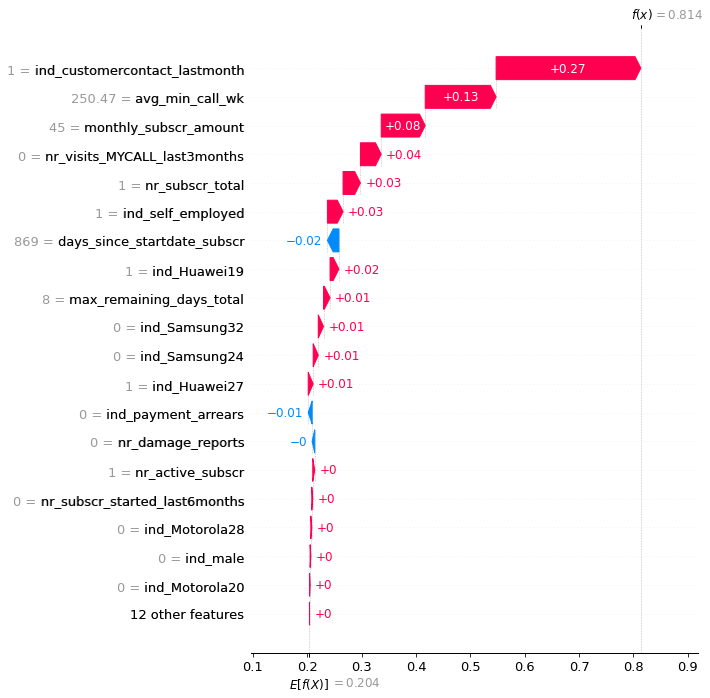

In [ ]:
import shap
explainer = shap.Explainer(rf, X_train_sample)
shap_values = explainer(X_train_sample,check_additivity=False)
shap.plots.waterfall(shap_values[:,:,1][j, :],max_display=20)

# LIME

Another method for explaining model predictions is LIME. Unlike SHAP, LIME does not support functionality for global interpretation. But we can use LIME to interpret individual predictions locally, like we just did with SHAP. We can instantiate a LIME explainer by calling `lime_tabular.LimeTabularExplainer()`:

In [ ]:
import numpy as np
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_sample.astype('int')),
    feature_names=X_train_sample.columns,
    class_names=['0', '1'],
    mode='classification'
)

Now let's use LIME to explain the same data point that we just explained with SHAP and compare the differences:

In [ ]:
exp = explainer.explain_instance(
    data_row=X_train_sample.astype('int').iloc[j], 
    predict_fn=rf.predict_proba
)

# exp.show_in_notebook(show_table=True) # Does not work in databricks

exp_html = exp.as_html()
displayHTML(exp_html) # good fix

Note that features are vertically sorted based on their importance for this specific prediction. In agreement with the SHAP explainer, `ind_customercontact_lastmonth` and `avg_min_call_wk` are the features that have the strongest positive effect on the predicted probability. However, for the features that contributed negatively to the probability, we see some differences between the two methods. For example, the negative effect of `ind_payment_arrears` seems to be more important according to LIME than it seems according to SHAP waterfall plot. The slight differences between the two methods are caused by the fact that SHAP and LIME work in a different way: SHAP iteratively removes features from predictions to evaluate the effect of that feature on the prediction. Conversely, LIME fits a local surrogate model, that only applies in vicinity of the data point being explained. Therefore, it seems that in vicinity to the data point of Jimmy, `ind_payment_arrears` has a stronger negative effect on the prediction compared to what SHAP would suggest. However, in general both methods suggest similar contributions of features, so I would not care too much about these differences.

## SHAP versus LIME: the verdict

We have now seen how SHAP and LIME can be used to open the black box of ML-models. At first sight, SHAP seems more versatile: it offers methods for both local and global interpretation of models, and there are multiple options with regard to visualization. In contrast, LIME only offers a method for local interpretation of models, and is more restricted in terms of visualization. So why would we ever use LIME? Well, if we look at the running time for SHAP, computing the SHAP values for a subset of only 5000 samples already took 3 minutes. Furthermore, if we look at the computation time for the SHAP waterfall plot, we see that it takes a very long time for the algorithm to compute the values that indicate the contribution of each variable to the output. Conversely, a similar plot in LIME computes much faster. Therefore, it can be a good practice to choose SHAP over LIME when you want to explain your model on a global level, or when you only want to explain a few specific predictions. In situations where you want to explain large volumes of predictions and SHAP gets too slow, LIME can be a nice alternative!